In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score, average_precision_score
import warnings
import cv2

# 训练集的csv文件填写示例，注意第一行要填列名，文件名不支持中文
# '.bmp', '.tiff', '.webp', '.gif'后缀的一致写成jpg因为这些格式会被处理成jpg

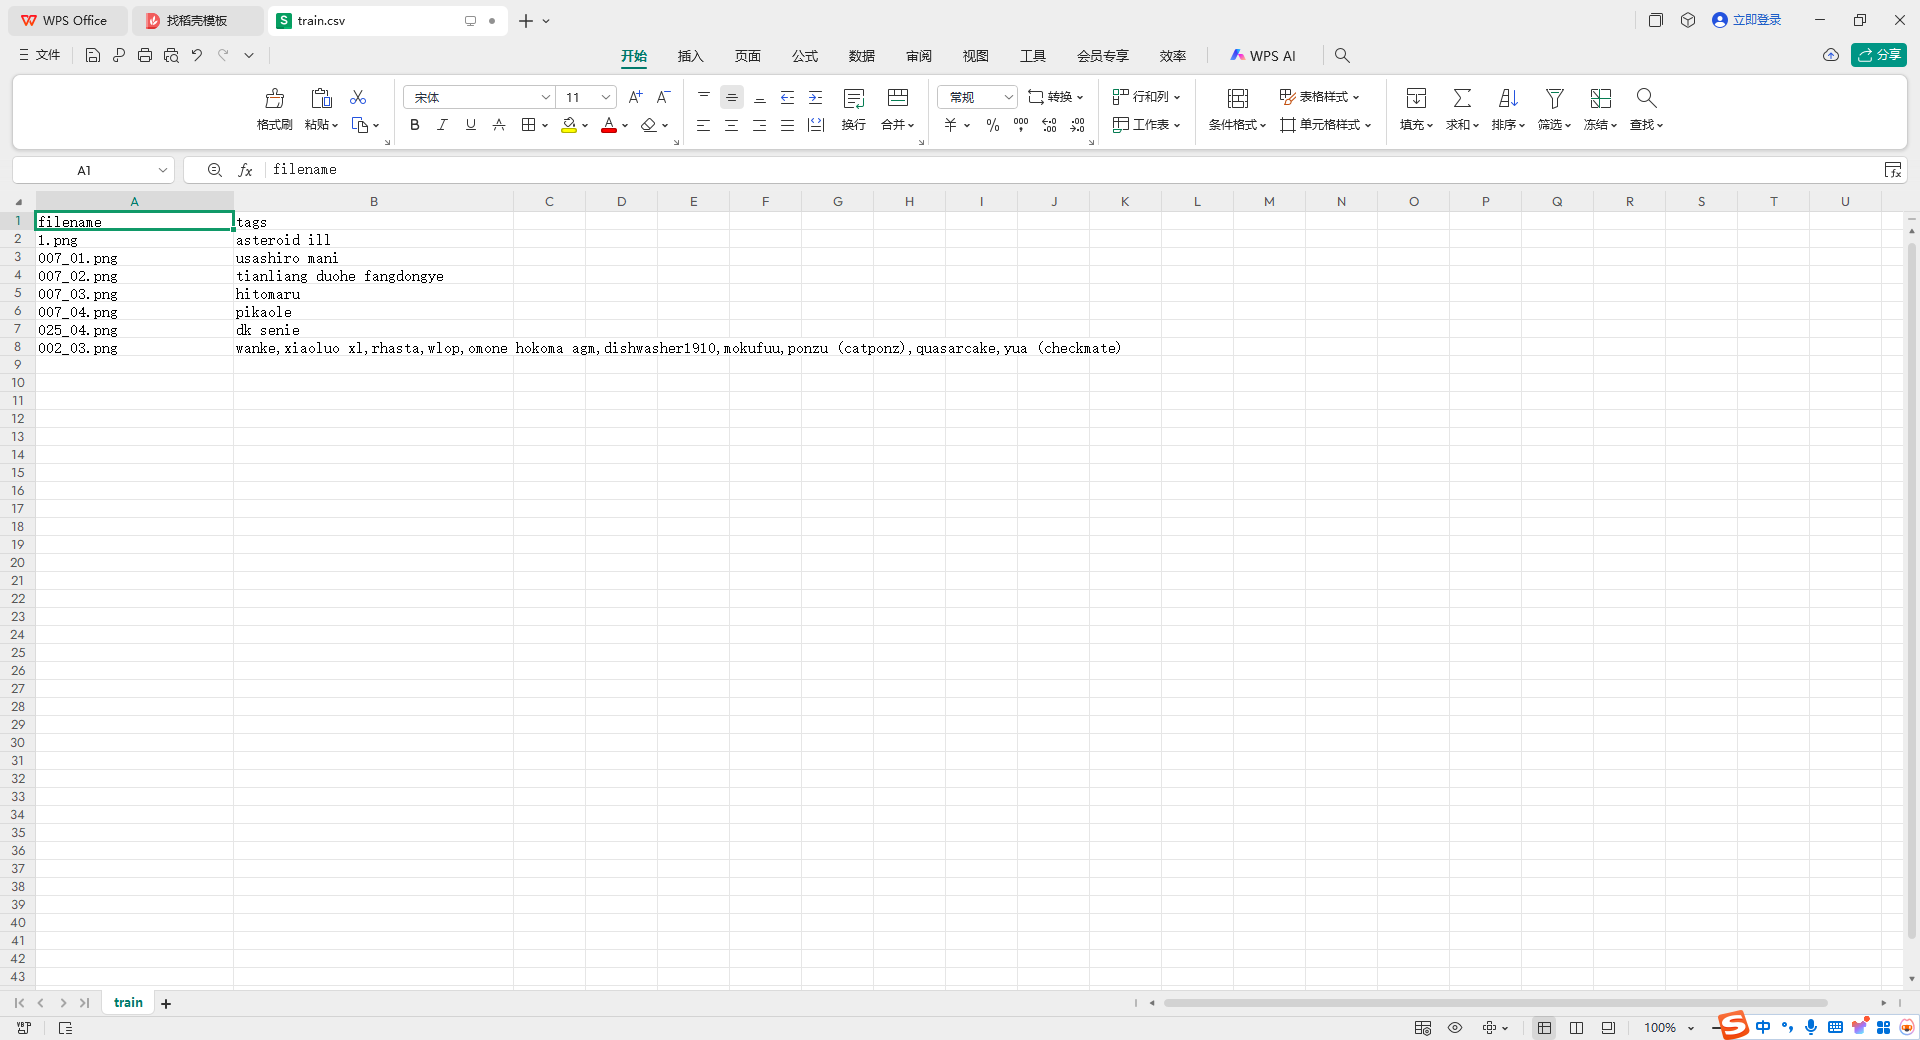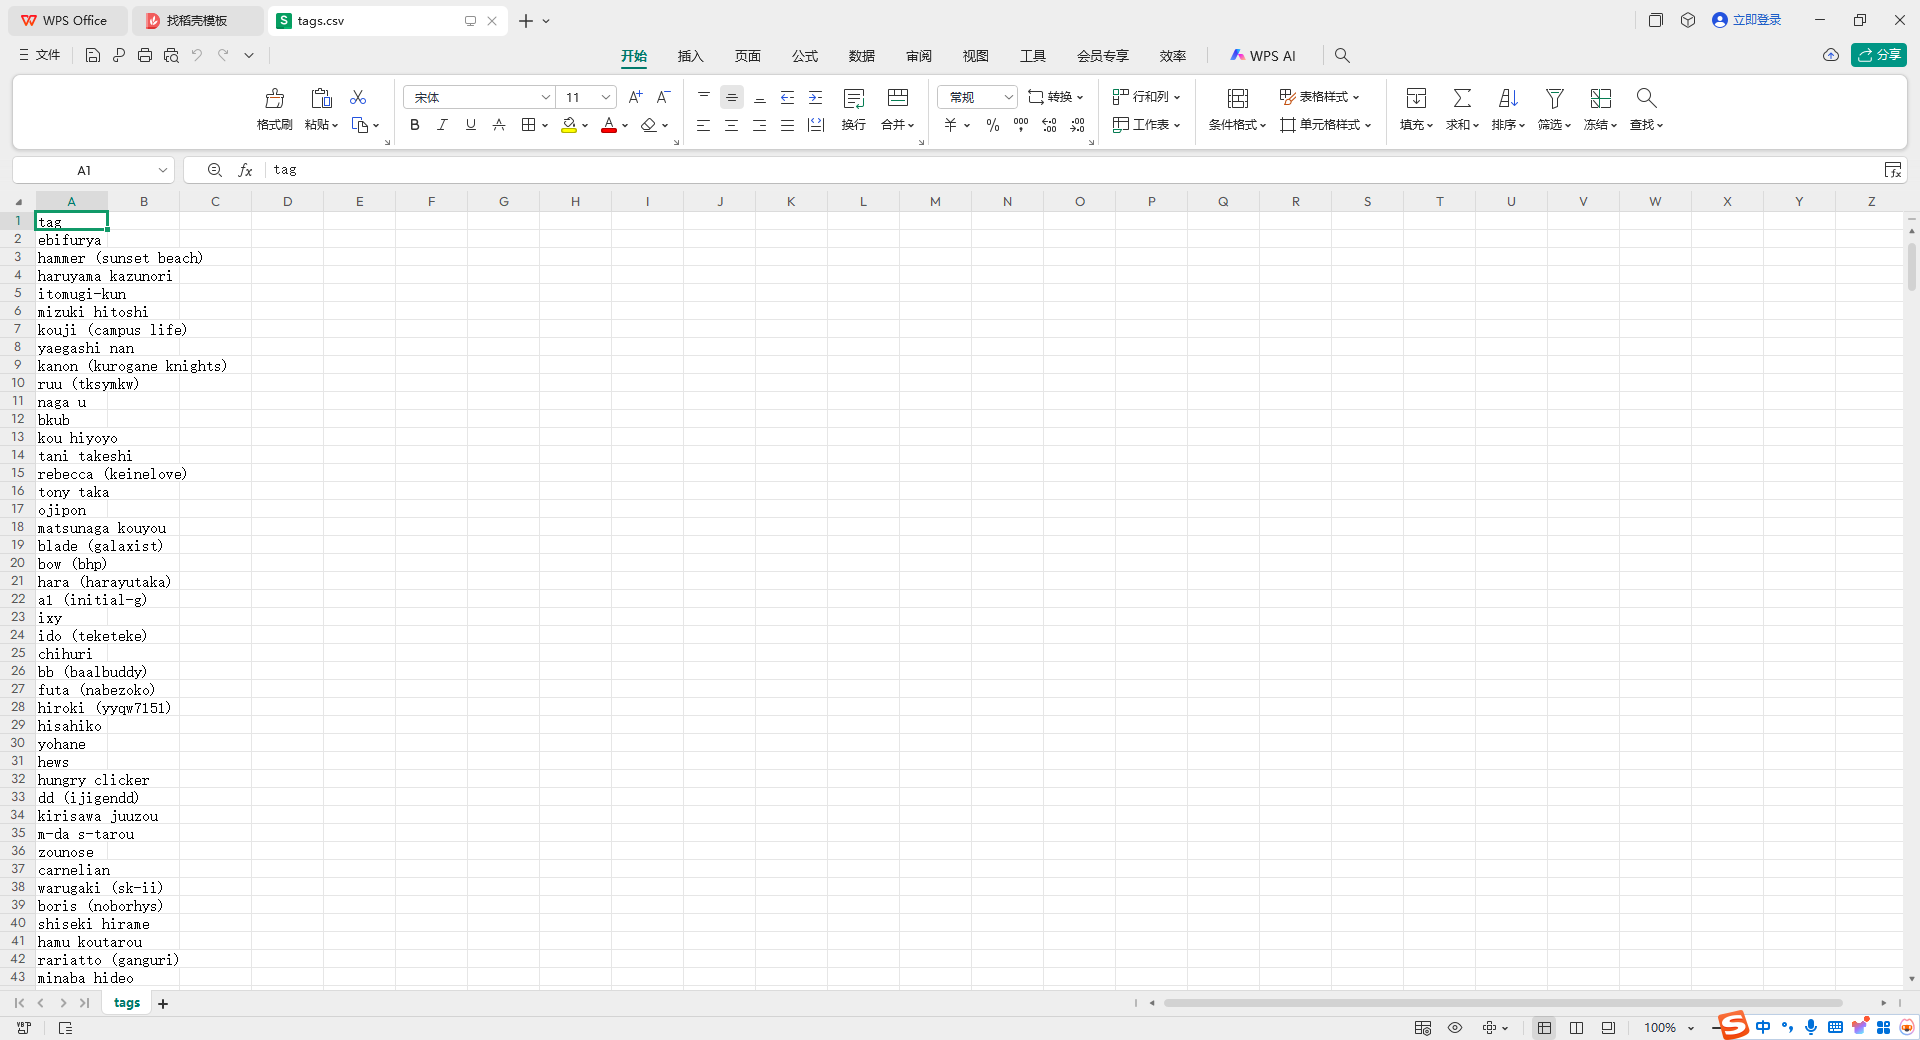

In [ ]:
# 输入训练集的目录
# 路径设置
# 根据实际情况修改,此目录下需要一个train.csv用于标注一个tags.csv表示映射列表（所有可能出现的标签）和一个images文件夹存放用于训练的图片
base_dir = 'D:/tagger/artist_tagger/train_example_folder'
# 替换为你要预测的图片所在的目录
img_dir = 'D:/tagger/artist_tagger/input_images'
# 模型输出位置(pth是模型后缀)
model_path = 'D:/tagger/artist_tagger/tagger.pth'
# 设置阈值，小于0表示使用自动阈值，大于等于0表示使用手动阈值，如果使用手动阈值最终预测结果只会输出大于此阈值的结果，手动阈值需要为0-1之间的一个值
threshold = -1  # 使用自动阈值，这里可以使用是因为有验证集，但实际上用户不一定有验证集，所以推荐使用手动阈值

In [ ]:
# 忽略特定警告
warnings.filterwarnings("ignore", category=UserWarning)

def convert_images_to_jpg(input_dir):
    supported_formats = ['.bmp', '.tiff', '.webp', '.gif']
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        if filename.lower().endswith('.jpg'):
            continue
        try:
            if filename.lower().endswith('.gif'):
                cap = cv2.VideoCapture(file_path)
                ret, frame = cap.read()
                if ret:
                    output_path = os.path.splitext(file_path)[0] + '.jpg'
                    cv2.imwrite(output_path, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                cap.release()
                os.remove(file_path)
            elif filename.lower().endswith(tuple(supported_formats)):
                img = Image.open(file_path).convert("RGB")
                output_path = os.path.splitext(file_path)[0] + '.jpg'
                img.save(output_path, "JPEG")
                img.close()
                if file_path != output_path:
                    os.remove(file_path)
            else:
                print(f"Unsupported file type: {filename}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

class ArtStyleDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, mlb=None):
        self.annotations = pd.read_csv(csv_file, encoding='latin1')
        self.img_dir = img_dir
        self.transform = transform
        self.mlb = mlb
        # 将字符串格式的列表转换回列表
        self.annotations['tags'] = self.annotations['tags'].apply(lambda x: x.split(','))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        try:
            image = Image.open(img_name).convert("RGB")
        except FileNotFoundError as e:
            print(f"Error loading image {img_name}: {e}")
            return None
        
        if self.transform:
            image = self.transform(image)

        labels = self.annotations.iloc[index]['tags']
        labels = self.mlb.transform([labels])[0]  # 直接传入标签列表
        labels = torch.tensor(labels, dtype=torch.float32)

        return image, labels

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))  # 过滤掉None值
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionModule, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class MultiLayerAttentionResNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiLayerAttentionResNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        
        # 提取 ResNet 的各层
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # 添加 SE Block 和空间注意力模块到每一层
        self.se_block1 = SEBlock(channel=self.layer1[-1].conv3.out_channels)
        self.spatial_attention1 = SpatialAttentionModule()
        
        self.se_block2 = SEBlock(channel=self.layer2[-1].conv3.out_channels)
        self.spatial_attention2 = SpatialAttentionModule()
        
        self.se_block3 = SEBlock(channel=self.layer3[-1].conv3.out_channels)
        self.spatial_attention3 = SpatialAttentionModule()
        
        self.se_block4 = SEBlock(channel=self.layer4[-1].conv3.out_channels)
        self.spatial_attention4 = SpatialAttentionModule()
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 添加多层感知机（MLP）
        self.mlp = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.layer0(x)
        
        x = self.layer1(x)
        x = self.se_block1(x)
        x = x * self.spatial_attention1(x)
        
        x = self.layer2(x)
        x = self.se_block2(x)
        x = x * self.spatial_attention2(x)
        
        x = self.layer3(x)
        x = self.se_block3(x)
        x = x * self.spatial_attention3(x)
        
        x = self.layer4(x)
        x = self.se_block4(x)
        x = x * self.spatial_attention4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        x = self.fc_layers(x)
        return x

train_csv_path = os.path.join(base_dir, 'train.csv')
original_img_dir = os.path.join(base_dir, 'images')

# 图像格式转换
convert_images_to_jpg(original_img_dir)
convert_images_to_jpg(img_dir)

# 加载标签信息并初始化 MultiLabelBinarizer
styles_df = pd.read_csv(os.path.join(base_dir, 'tags.csv'), encoding='latin1')  # 确保正确的编码
styles = styles_df['tag'].tolist()  # 确保列名正确
mlb = MultiLabelBinarizer()
mlb.fit([[style] for style in styles])  # 每个标签作为一个单独的样本

df = pd.read_csv(train_csv_path, encoding='latin1')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=True)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ArtStyleDataset(csv_file=train_csv_path, img_dir=original_img_dir, transform=transform_train, mlb=mlb)
val_dataset = ArtStyleDataset(csv_file=train_csv_path, img_dir=original_img_dir, transform=transform_val, mlb=mlb)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = 4 if torch.cuda.is_available() else 0
pin_memory = True if torch.cuda.is_available() else False

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=pin_memory, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, collate_fn=collate_fn)

model = MultiLayerAttentionResNet(num_classes=len(styles))
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6, last_epoch=-1)
criterion = nn.BCEWithLogitsLoss()

best_val_loss = float('inf')
patience = 5
triggers = 0

phases = [
    {'name': 'phase_1', 'epochs': 30, 'lr': 0.001},
    {'name': 'phase_2', 'epochs': 20, 'lr': 0.0001}
]

for phase in phases:
    optimizer.param_groups[0]['lr'] = phase['lr']
    for epoch in range(phase['epochs']):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            if inputs is None or labels is None:  # 跳过无效样本
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
            optimizer.step()
            
            running_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        y_true_all = []
        y_pred_all = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                if inputs is None or labels is None:  # 跳过无效样本
                    continue
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                probabilities = torch.sigmoid(outputs).cpu().numpy()
                y_true_all.extend(labels.cpu().numpy())
                y_pred_all.extend(probabilities)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"[{phase['name']} Epoch {epoch + 1}/{phase['epochs']}] Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}, Learning Rate: {current_lr}")
        
        y_true_all = np.array(y_true_all)
        y_pred_all = np.array(y_pred_all)
        
        # 计算F1 Score
        y_pred_binary = (y_pred_all > 0.3).astype(int)
        f1_micro = f1_score(y_true_all, y_pred_binary, average='micro')
        f1_macro = f1_score(y_true_all, y_pred_binary, average='macro')
        ap_score = average_precision_score(y_true_all, y_pred_all, average='macro')
        
        print(f"F1 Micro: {f1_micro:.4f}, F1 Macro: {f1_macro:.4f}, Average Precision Score: {ap_score:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = model.state_dict().copy()
            triggers = 0
        else:
            triggers += 1
            if triggers >= patience:
                print("Early stopping!")
                break

# 加载最佳模型权重
try:
    model.load_state_dict(torch.load(model_path))
    print("Model weights loaded successfully.")
except Exception as e:
    print(f"Failed to load model weights: {e}")

torch.save(model.state_dict(), model_path)

# 打印训练时使用的标签类别
print("Training Classes:", mlb.classes_)

# 在验证集上计算ROC曲线和AUC
y_true_all = []
y_pred_all = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        if inputs is None or labels is None:  # 跳过无效样本
            continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        y_true_all.extend(labels.cpu().numpy())
        y_pred_all.extend(probabilities)

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# 计算每个类别的ROC曲线和AUC
roc_auc = dict()
optimal_thresholds = dict()

for i, label in enumerate(mlb.classes_):
    fpr, tpr, thresholds = roc_curve(y_true_all[:, i], y_pred_all[:, i])
    if len(np.unique(y_true_all[:, i])) <= 1:
        print(f"No positive samples for class '{label}'. Skipping AUC calculation.")
        optimal_thresholds[label] = 0.3  # 默认阈值
    else:
        roc_auc[i] = auc(fpr, tpr)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_thresholds[label] = thresholds[optimal_idx]

print("Optimal Thresholds:", optimal_thresholds)

In [ ]:
def predict_image_styles(img_path, model, transform, label_encoder, threshold, device=device):
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error opening image {img_path}: {e}")
        return {}
    
    if transform:
        image = transform(image)
    
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.sigmoid(outputs)  # 使用sigmoid函数将输出转换为概率
        probabilities = probabilities.cpu().numpy().flatten()

    if threshold < 0:
        style_prob_dict = {label: prob for label, prob in zip(label_encoder.classes_, probabilities) if prob > optimal_thresholds.get(label, 0.3)}
    else:
        style_prob_dict = {label: prob for label, prob in zip(label_encoder.classes_, probabilities) if prob > threshold}

    sorted_style_prob_dict = dict(sorted(style_prob_dict.items(), key=lambda item: item[1], reverse=True))

    return sorted_style_prob_dict


# 加载模型
try:
    model.load_state_dict(torch.load(model_path))
    print("Model weights loaded successfully.")
except Exception as e:
    print(f"Failed to load model weights: {e}")

model = model.to(device)
model.eval()

for filename in os.listdir(img_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        img_path = os.path.join(img_dir, filename)
        predictions = predict_image_styles(img_path, model, transform_val, mlb, threshold, device)
        print(f"Predictions for {filename}: {predictions}")

print("Classes:", mlb.classes_)